In [1]:
import os
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
from torch.autograd import Variable

import numpy as np
from pymoo.problems.functional import FunctionalProblem
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
from time import time
# Start timer
import datetime
from sklearn import datasets
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM


In [2]:
# Load MNIST Data into np arrays
(train_X, train_y), (test_X, test_y) = mnist.load_data()
# Concatenate training and testing
X = np.concatenate([train_X, test_X], axis=0).reshape((70000, 28*28))
y = np.append(train_y, test_y)
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#*********** Split the data set into training and testing**********#
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2,train_size=0.8)
# Converting to torch
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

batch_num = 5600 #10 data points

In [3]:
#The Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(784, 20)
        self.layer2 = nn.Linear(20,20)
        self.layer3 = nn.Linear(20,10)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x
    
    def get_learnable_params(self,):
        model_l_params = self.state_dict()
        dict_params = {}
        for name, l_param in model_l_params.items():
            dict_params[name] = l_param
            
        return dict_params

In [4]:
# Function to flatten the parameters
def get_num_elmts(dict_params):
    
    N = 0
    for name in list(dict_params.keys()):
        N +=  dict_params[name].numel()    
    # Flatten the list of tensors into a single list of elements
    flattened_list = [element.item() for tensor in list(dict_params.values()) for element in tensor.view(-1)]

    return N, flattened_list

In [5]:
# Calling parameters that would be used by the objective functions in the EA
model = NeuralNetwork() 
dict_params = model.get_learnable_params()
N, initial_params = get_num_elmts(dict_params)
xl_is, xu_is = 100*min(initial_params), 100*max(initial_params)
#list(dict_params.keys())


criterion = nn.CrossEntropyLoss()

In [6]:

# Defining the objective functions (Stochastic setting)
def objective1(X_params):
    
    X_params = torch.tensor(X_params)
    model_params = model.state_dict()
    start_k, end_k = 0, 0

    for name, param in model_params.items():
        end_k = start_k + dict_params[name].numel()
        
        flat_tensor = X_params[start_k:end_k]
        # print("flat_tensor: ", flat_tensor.shape)
        #print("param: ", param.shape)
        new_param = flat_tensor.view(param.shape)
        param.copy_(new_param)
        
        start_k = end_k
    
    model.train()
    #for epoch in range(50):
    train_loss = 0.0
        
    # Shuffle the training data
    permutation = torch.randperm(X_train.shape[0])
    # Split the training data into mini-batches
    for i in range(0, X_train.shape[0], batch_num):
        indices = permutation[i:i+batch_num]
        batch_X, batch_y = X_train[indices], y_train[indices]

        outputs = model(batch_X) #.float()
        loss =  criterion(outputs, batch_y)

        train_loss += loss.item()

    train_loss = train_loss / (X_train.shape[0] / batch_num)
    #print("Average train_loss", train_loss)

    # Objective 1: Cross-Entropy Loss
    obj1 = train_loss

    # Objective 2: L1 Norm
    #obj2 = torch.abs(model.layer1.weight).sum() + torch.abs(model.layer1.bias).sum()
    #obj2 += torch.abs(model.layer2.weight).sum() + torch.abs(model.layer2.bias).sum()
    #obj2 += torch.abs(model.layer3.weight).sum() + torch.abs(model.layer3.bias).sum()
                
    # Convert obj1 and obj2 to tensors
    obj1 = torch.tensor([obj1])
    
    return obj1.cpu().detach()
    


def objective2(X_params):
    # Objective 2: L1 Norm
    obj2 = torch.abs(model.layer1.weight).sum() + torch.abs(model.layer1.bias).sum()
    obj2 += torch.abs(model.layer2.weight).sum() + torch.abs(model.layer2.bias).sum()
    obj2 += torch.abs(model.layer3.weight).sum() + torch.abs(model.layer3.bias).sum()

    #print("obj2", obj2)            
    
    return obj2.cpu().detach()

In [7]:
objs = [objective1, objective2]

n_var = N

problem = FunctionalProblem(n_var,
                            objs,
                            xl= xl_is,
                            xu= xu_is,
                            )

In [8]:
ref_dirs = get_reference_directions("uniform", 2, n_partitions=45)


algorithm = MOEAD(
    ref_dirs,
    n_neighbors=15,
    prob_neighbor_mating=0.7,
)

"""

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
"""

'\n\nalgorithm = NSGA2(\n    pop_size=100,\n    n_offsprings=10,\n    sampling=FloatRandomSampling(),\n    crossover=SBX(prob=0.9, eta=15),\n    mutation=PM(eta=20),\n    eliminate_duplicates=True\n)\n'

In [9]:
# Start timer
print(datetime.datetime.now())
t0 = time()

res = minimize(problem,
               algorithm,
               ('n_gen', 100),
               seed=1,
               verbose=True)

T_norm_1 = time()-t0
# Print computation time
print('\nComputation time: {} secs'.format(T_norm_1))
print(datetime.datetime.now())

# Decision Space
X_pareto_front = res.X
#Objective Space
F_pareto_front = res.F

# Specify the folder name
folder_name = 'Results'

# Create the new folder if it doesn't exist
os.makedirs(folder_name, exist_ok=True)

# Specify the path to the new file
file_path_1 = os.path.join(folder_name, 'mnist_X_pareto_front.txt')
file_path_2 = os.path.join(folder_name, 'mnist_F_pareto_front.txt')

# Save the NumPy array as a .txt file in the new folder
np.savetxt(file_path_1, X_pareto_front)
np.savetxt(file_path_2, F_pareto_front)

2024-01-22 17:20:04.043717


c:\Users\Augustina\AppData\Local\Programs\Python\Python38\lib\site-packages\pymoo\problems\functional.py:39: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  out["F"] = np.array([obj(x) for obj in self.objs])


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       46 |      4 |             - |             -
     2 |       92 |     24 |  0.0644836546 |         ideal
     3 |      138 |     27 |  0.1224930761 |         ideal
     4 |      184 |     15 |  2.817312E+03 |         ideal
     5 |      230 |     31 |  1.8425390146 |         ideal
     6 |      276 |     18 |  4.4928571429 |         ideal
     7 |      322 |     15 |  4.371562E+02 |         ideal
     8 |      368 |     25 |  1.0634328358 |         ideal
     9 |      414 |     32 |  1.056414E+02 |         ideal
    10 |      460 |     15 |  5.555938E+02 |         ideal
    11 |      506 |     30 |  2.244444E+01 |         ideal
    12 |      552 |     18 |  1.4116379310 |         ideal
    13 |      598 |     30 |  0.1738796109 |         ideal
    14 |      644 |     25 |  0.1552803399 |         ideal
    15 |      690 |     19 |  0.2820220929 |         ideal
    16 |      736 |     16 |  0.6954173917 |         ide

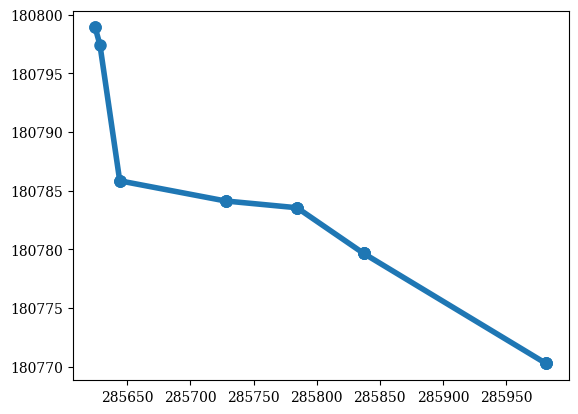

In [19]:
#Plot objective (train)
#Scatter().add(res.F).show()
F_pareto_front = np.loadtxt('Results/mnist_F_pareto_front.txt')
plt.plot(F_pareto_front[:, 0], F_pareto_front[:, 1],"-o",  label = "train (EA)" , linewidth = 4, markersize= 8)

In [11]:
# Number of points found on the Pareto Front
len(res.F)

31

In [12]:
# Testing on the test set.
def eval_optimal(list_X_params):
    
    best_accu = 0.0
    best_opt = 0
    
    for opt, X_params in enumerate(list_X_params):
        print("-----------------------------------")
        print(f"------ Optimal Point No {opt+1}/{len(list_X_params)} ------")
        print("-----------------------------------")
        X_params = torch.tensor(X_params)
        model_params = model.state_dict()
        start_k, end_k = 0, 0
        for name, param in model_params.items():
            end_k = start_k + dict_params[name].numel()
            
            flat_tensor = X_params[start_k:end_k]
            # print("flat_tensor: ", flat_tensor.shape)
            # print("param: ", param.shape)
            new_param = flat_tensor.view(param.shape)
            param.copy_(new_param)
            
            start_k = end_k
            
        model.eval()
        correct = 0
        total = 0
        test_loss = []
        #for epoch in enumerate(X_test):
        outputs = model(X_test)
        loss =  criterion(outputs, y_test)
        test_loss.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()
        accuracy = 100 * correct / total
        
        # val_loss = val_loss/len(val_loader) 
        
        if(best_accu < accuracy):
            best_accu = accuracy
            BEST_val_accu = accuracy
            best_opt = opt
        
        if best_accu > 0:
            # act_bst_accu = max([act_bst_accu, val_accuracy.mean().item()])
            print('\nValidation set: Average Accuracy: {:.2f}%    (Best: {:.2f}%)\n'.format(
                    accuracy, best_accu))
        else:
            print('\nValidation set: Average Accuracy: ({:.2f}%)\n'.format(
                    accuracy))
            
    return BEST_val_accu, best_opt

In [13]:
LIST_pts = (res.X).tolist()
is_BEST_val_accu, is_best_opt = eval_optimal(LIST_pts)

-----------------------------------
------ Optimal Point No 1/31 ------
-----------------------------------

Validation set: Average Accuracy: 16.54%    (Best: 16.54%)

-----------------------------------
------ Optimal Point No 2/31 ------
-----------------------------------

Validation set: Average Accuracy: 16.58%    (Best: 16.58%)

-----------------------------------
------ Optimal Point No 3/31 ------
-----------------------------------

Validation set: Average Accuracy: 16.58%    (Best: 16.58%)

-----------------------------------
------ Optimal Point No 4/31 ------
-----------------------------------

Validation set: Average Accuracy: 16.58%    (Best: 16.58%)

-----------------------------------
------ Optimal Point No 5/31 ------
-----------------------------------

Validation set: Average Accuracy: 16.58%    (Best: 16.58%)

-----------------------------------
------ Optimal Point No 6/31 ------
-----------------------------------

Validation set: Average Accuracy: 16.58%    (B